<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/SAMed_BraTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customized Segment Anything Model for Medical Image Segmentation
### [[Paper](https://arxiv.org/pdf/2304.13785.pdf)] [[Github](https://github.com/hitachinsk/SAMed)]
---
[Kaidong Zhang](https://hitachinsk.github.io/), and [Dong Liu](https://faculty.ustc.edu.cn/dongeliu/), technical report, 2023

All rights reserved by the authors of SAMed

We provide the entire inference pipeline in this page.

# Setup environment

In [1]:
!pip install -q einops==0.6.1 icecream==2.1.3 MedPy==0.4.0 monai==1.1.0 opencv_python==4.5.4.58 SimpleITK==2.2.1 tensorboardX==2.6 ml-collections==0.1.1 onnx==1.13.1 onnxruntime==1.14.1 tensorboardX torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 847.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

# Download codes, pretrained weights and test data

In [2]:
# prepare codes
import os
CODE_DIR = 'samed_codes'
os.makedirs(f'./{CODE_DIR}')
!git clone https://github.com/hitachinsk/SAMed.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

Cloning into 'samed_codes'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 225 (delta 86), reused 72 (delta 72), pack-reused 123
Receiving objects: 100% (225/225), 635.01 KiB | 3.34 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [4]:
#dataset
!gdown https://drive.google.com/uc?id=1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv
import zipfile
with zipfile.ZipFile('Slices.zip', 'r') as zip_ref:
    zip_ref.extractall()

#weights
!gdown https://drive.google.com/uc?id=1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr #'epoch_159.pth'
!gdown https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg #'sam_vit_b_01ec64.pth'

Downloading...
From: https://drive.google.com/uc?id=1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv
To: /content/samed_codes/Slices.zip
100% 56.1M/56.1M [00:00<00:00, 65.9MB/s]


Dataloader:

Train Sample: 1395 Test Sample: 310


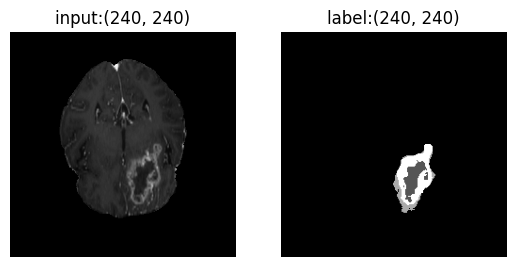

In [14]:
from torch.utils.data import Dataset, DataLoader
from glob import glob
import imageio.v2 as iio
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def map_labels(label):
    label_map = {0: 0, 85: 1, 170: 2, 255: 3}
    mapped_label = label.copy()
    for k, v in label_map.items():
        mapped_label[label == k] = v
    return mapped_label

class BratsDataset(Dataset):
    def __init__(self, root='brats_train'):
        self.img_path_all = glob(root + '/BraTS-GLI-t1c/*.png')
        self.mask_path_all = [img_path.replace('t1c', 'seg') for img_path in self.img_path_all]

    def __len__(self):
      return len(self.img_path_all)

    def __getitem__(self, index):
        image = iio.imread(self.img_path_all[index])
        image = normalise_intensity(image)
        label = iio.imread(self.mask_path_all[index])
        label = map_labels(label)
        return image, label

train_dataset = BratsDataset(root='Slices/Train')
test_dataset = BratsDataset(root='Slices/Test')
print('Train Sample:', len(train_dataset), 'Test Sample:', len(test_dataset))
input, label = test_dataset[33]
plt.subplot(1,2,1), plt.axis('OFF'), plt.title('input:{}'.format(input.shape)), plt.imshow(input, cmap='gray')
plt.subplot(1,2,2), plt.axis('OFF'), plt.title('label:{}'.format(label.shape)), plt.imshow(label, cmap='gray');

SAM Testing

In [6]:
%cd /content/samed_codes
import os
import sys
from tqdm import tqdm
import logging
import numpy as np
import argparse
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
# from utils import test_single_volume
from importlib import import_module
from segment_anything import sam_model_registry
from datasets.dataset_synapse import Synapse_dataset
from icecream import ic
from medpy import metric
from scipy.ndimage import zoom
import torch.nn as nn
import SimpleITK as sitk
import torch.nn.functional as F
import imageio
from einops import repeat

/content


In [21]:
def seed_everything(seed=42):
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='testset/test_vol_h5/')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=3)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='/output')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=4, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    args = parser.parse_args([])
    args.output_dir = 'results'
    args.ckpt = 'sam_vit_b_01ec64.pth'
    args.lora_ckpt = 'epoch_159.pth'

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed_everything()
    os.makedirs(args.output_dir, exist_ok = True)

    sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                                    num_classes=args.num_classes,
                                                                    checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                                    pixel_std=[1, 1, 1])

    pkg = import_module(args.module)
    net = pkg.LoRA_Sam(sam, args.rank).cuda()
    net.load_lora_parameters(args.lora_ckpt)
    multimask_output = True if args.num_classes > 1 else False




RuntimeError: ignored

Old data

In [15]:
!gdown https://drive.google.com/uc?id=1RczbNSB37OzPseKJZ1tDxa5OO1IIICzK
!unzip test_vol_h5.zip

Downloading...
From: https://drive.google.com/uc?id=1RczbNSB37OzPseKJZ1tDxa5OO1IIICzK
To: /content/samed_codes/test_vol_h5.zip
100% 267M/267M [00:02<00:00, 104MB/s]
Archive:  test_vol_h5.zip
   creating: test_vol_h5/
  inflating: test_vol_h5/case0038.npy.h5  
  inflating: test_vol_h5/case0036.npy.h5  
  inflating: test_vol_h5/case0035.npy.h5  
  inflating: test_vol_h5/case0032.npy.h5  
  inflating: test_vol_h5/case0029.npy.h5  
  inflating: test_vol_h5/case0025.npy.h5  
  inflating: test_vol_h5/case0022.npy.h5  
  inflating: test_vol_h5/case0008.npy.h5  
  inflating: test_vol_h5/case0004.npy.h5  
  inflating: test_vol_h5/case0003.npy.h5  
  inflating: test_vol_h5/case0001.npy.h5  
  inflating: test_vol_h5/case0002.npy.h5  


In [18]:
import h5py
filepath = '/content/samed_codes/test_vol_h5/case0001.npy.h5'
data = h5py.File(filepath)
image, label = data['image'][:], data['label'][:]
image.shape, label.shape, np.unique(label)

((147, 512, 512),
 (147, 512, 512),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=float32))

# Execute SAMed

Testing:

In [ ]:
%cd /content/samed_codes
import os
import sys
from tqdm import tqdm
import logging
import numpy as np
import argparse
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
# from utils import test_single_volume
from importlib import import_module
from segment_anything import sam_model_registry
from datasets.dataset_synapse import Synapse_dataset
from icecream import ic
from medpy import metric
from scipy.ndimage import zoom
import torch.nn as nn
import SimpleITK as sitk
import torch.nn.functional as F
import imageio
from einops import repeat



class_to_name = {1: 'spleen', 2: 'right kidney', 3: 'left kidney', 4: 'gallbladder', 5: 'liver', 6: 'stomach', 7: 'aorta', 8: 'pancreas'}

def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0 and gt.sum() > 0:
        dice = metric.binary.dc(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        return dice, hd95
    elif pred.sum() > 0 and gt.sum() == 0:
        return 1, 0
    else:
        return 0, 0

def test_single_volume(image, label, net, classes, multimask_output, image_size=[512, 512],
                       test_save_path=None, case=None):
    image, label = image.squeeze(0).cpu().detach().numpy(), label.squeeze(0).cpu().detach().numpy()
    print('image, label:', image.shape, label.shape )

    prediction = np.zeros_like(label)
    for ind in range(image.shape[0]):
        slice = image[ind, :, :]
        x, y = slice.shape[0], slice.shape[1]
        inputs = torch.from_numpy(slice).unsqueeze(0).unsqueeze(0).float().cuda()
        inputs = repeat(inputs, 'b c h w -> b (repeat c) h w', repeat=3)
        net.eval()
        with torch.no_grad():
            # print('model input:', inputs.shape)
            outputs = net(inputs, multimask_output, image_size[0])
            output_masks = outputs['masks']
            out = torch.argmax(torch.softmax(output_masks, dim=1), dim=1).squeeze(0)
            out = out.cpu().detach().numpy()
            out_h, out_w = out.shape
            if x != out_h or y != out_w:
                pred = zoom(out, (x / out_h, y / out_w), order=0)
            else:
                pred = out
            prediction[ind] = pred

    metric_list = []
    for i in range(1, classes + 1):
        metric_list.append(calculate_metric_percase(prediction == i, label == i))

    return metric_list

def inference(args, multimask_output, db_config, model, test_save_path=None):
    db_test = db_config['Dataset'](base_dir=args.volume_path, list_dir=args.list_dir, split='test_vol')
    print('sample size:', len(db_test))
    testloader = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=1)
    logging.info(f'{len(testloader)} test iterations per epoch')
    model.eval()
    metric_list = 0.0
    for i_batch, sampled_batch in tqdm(enumerate(testloader)):
        h, w = sampled_batch['image'].shape[2:]
        image, label, case_name = sampled_batch['image'], sampled_batch['label'], sampled_batch['case_name'][0]
        print(image.shape, label.shape)
        metric_i = test_single_volume(image, label, model, classes=args.num_classes, multimask_output=multimask_output,
                                      image_size=[args.img_size, args.img_size],
                                      test_save_path=test_save_path, case=case_name)
        metric_list += np.array(metric_i)
        print('idx %d case %s mean_dice %f mean_hd95 %f' % (
            i_batch, case_name, np.mean(metric_i, axis=0)[0], np.mean(metric_i, axis=0)[1]))
        logging.info('idx %d case %s mean_dice %f mean_hd95 %f' % (
            i_batch, case_name, np.mean(metric_i, axis=0)[0], np.mean(metric_i, axis=0)[1]))
        if i_batch == 0:
            break
    metric_list = metric_list / len(db_test)
    for i in range(1, args.num_classes + 1):
        try:
            logging.info('Mean class %d name %s mean_dice %f mean_hd95 %f' % (i, class_to_name[i], metric_list[i - 1][0], metric_list[i - 1][1]))
        except:
            logging.info('Mean class %d mean_dice %f mean_hd95 %f' % (i, metric_list[i - 1][0], metric_list[i - 1][1]))
    performance = np.mean(metric_list, axis=0)[0]
    mean_hd95 = np.mean(metric_list, axis=0)[1]
    logging.info('Testing performance in best val model: mean_dice : %f mean_hd95 : %f' % (performance, mean_hd95))
    logging.info("Testing Finished!")
    return 1


def config_to_dict(config):
    items_dict = {}
    with open(config, 'r') as f:
        items = f.readlines()
    for i in range(len(items)):
        key, value = items[i].strip().split(': ')
        items_dict[key] = value
    return items_dict

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='testset/test_vol_h5/')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=8)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='/output')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=4, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    args = parser.parse_args([])
    args.volume_path = 'test_vol_h5'
    args.output_dir = 'results'
    args.ckpt = 'sam_vit_b_01ec64.pth'
    args.lora_ckpt = 'epoch_159.pth'

    if args.config is not None:
        # overwtite default configurations with config file\
        config_dict = config_to_dict(args.config)
        for key in config_dict:
            setattr(args, key, config_dict[key])

    if not args.deterministic:
        cudnn.benchmark = True
        cudnn.deterministic = False
    else:
        cudnn.benchmark = False
        cudnn.deterministic = True
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    dataset_name = args.dataset
    dataset_config = {
        'Synapse': {
            'Dataset': Synapse_dataset,
            'volume_path': args.volume_path,
            'list_dir': args.list_dir,
            'num_classes': args.num_classes,
            'z_spacing': 1
        }
    }
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)

    # register model
    sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                                    num_classes=args.num_classes,
                                                                    checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                                    pixel_std=[1, 1, 1])

    pkg = import_module(args.module)
    net = pkg.LoRA_Sam(sam, args.rank).cuda()

    assert args.lora_ckpt is not None
    net.load_lora_parameters(args.lora_ckpt)

    if args.num_classes > 1:
        multimask_output = True
    else:
        multimask_output = False

    # initialize log
    log_folder = os.path.join(args.output_dir, 'test_log')
    os.makedirs(log_folder, exist_ok=True)
    logging.basicConfig(filename=log_folder + '/' + 'log.txt', level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
    logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
    logging.info(str(args))

    if args.is_savenii:
        test_save_path = os.path.join(args.output_dir, 'predictions')
        os.makedirs(test_save_path, exist_ok=True)
    else:
        test_save_path = None
    inference(args, multimask_output, dataset_config[dataset_name], net, test_save_path)

/content/samed_codes
sample size: 12


0it [00:00, ?it/s]

torch.Size([1, 148, 512, 512]) torch.Size([1, 148, 512, 512])
image, label: (148, 512, 512) (148, 512, 512)


0it [02:27, ?it/s]

idx 0 case case0008 mean_dice 0.681535 mean_hd95 16.097952


Testing with command:

In [ ]:
%%bash
python test.py --volume_path test_vol_h5 --output_dir results --ckpt sam_vit_b_01ec64.pth --lora_ckpt epoch_159.pth